读取Mnist数据集

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import requests

#下载好的数据路径
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

#下载路径
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

#判断，如果本地找到不就去网址下载
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip
#解压数据
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

随便找一个数据进行展示

(50000, 784)


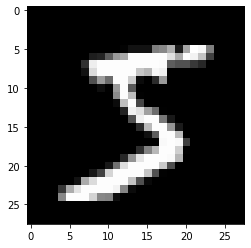

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

据需转换成tensor才能参与后续建模训练

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

创建一个model来更简化代码

In [7]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [8]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [9]:
for name, parameter in net.named_parameters():
    print(name, parameter.size())

hidden1.weight torch.Size([128, 784])
hidden1.bias torch.Size([128])
hidden2.weight torch.Size([256, 128])
hidden2.bias torch.Size([256])
out.weight torch.Size([10, 256])
out.bias torch.Size([10])


使用TensorDataset和DataLoader来构建数据

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs = 64#batch

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs )

In [12]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),#训练集需要打乱顺序
        DataLoader(valid_ds, batch_size=bs ),
    )

定义损失函数

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy


- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [15]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

返回模型及参数

In [16]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

更新梯度

In [17]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

正式训练

In [18]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2726043128967284
当前step:1 验证集损失：2.234999133682251
当前step:2 验证集损失：2.1778956016540527
当前step:3 验证集损失：2.0878043418884276
当前step:4 验证集损失：1.9462217262268067
当前step:5 验证集损失：1.7370460273742676
当前step:6 验证集损失：1.4746542064666748
当前step:7 验证集损失：1.216790439605713
当前step:8 验证集损失：1.0097251880645752
当前step:9 验证集损失：0.8583402508735657
当前step:10 验证集损失：0.7489207116127015
当前step:11 验证集损失：0.6686990942955017
当前step:12 验证集损失：0.6085442419052124
当前step:13 验证集损失：0.5625747427940369
当前step:14 验证集损失：0.5255164709568023
当前step:15 验证集损失：0.4961316279888153
当前step:16 验证集损失：0.47219176416397096
当前step:17 验证集损失：0.4523405352115631
当前step:18 验证集损失：0.43550137610435485
当前step:19 验证集损失：0.42135490441322326
当前step:20 验证集损失：0.4088140121459961
当前step:21 验证集损失：0.3981971092939377
当前step:22 验证集损失：0.3887441632986069
当前step:23 验证集损失：0.3809287321805954
当前step:24 验证集损失：0.3729370213270187
